#Directory, Libraries, and Data

In [109]:
%cd /content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet

/content/drive/MyDrive/Business Analyst course/Predictive Analytics/Prophet


In [110]:
#Libraries
import numpy as np
import pandas as pd
from prophet import Prophet

In [111]:
#Loading the data
df=pd.read_csv("Udemy_wikipedia_visits.csv")
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


<Axes: >

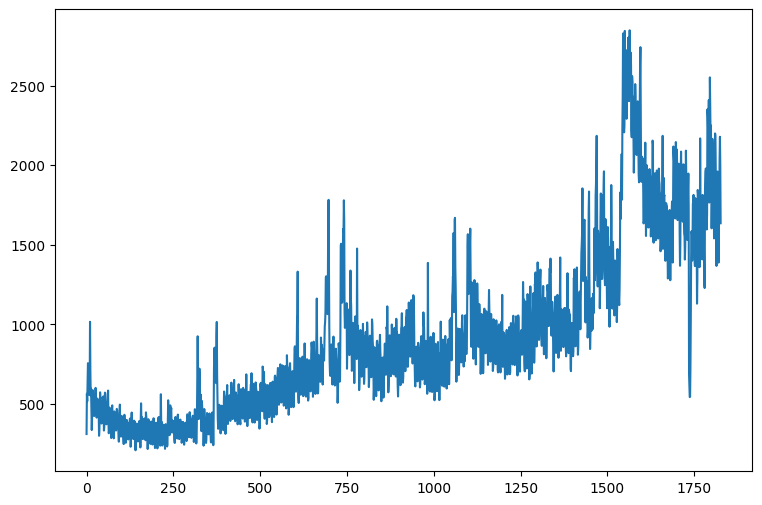

In [112]:
#Plot
df.Udemy.plot(figsize=(9,6))

#Data preparation

In [113]:
#Date variable
df.Date=pd.to_datetime(df.Date,
                       format="%m/%d/%Y")
df.Date

0      2016-01-01
1      2016-01-02
2      2016-01-03
3      2016-01-04
4      2016-01-05
          ...    
1822   2020-12-27
1823   2020-12-28
1824   2020-12-29
1825   2020-12-30
1826   2020-12-31
Name: Date, Length: 1827, dtype: datetime64[ns]

In [114]:
#Renaming variables
df=df.rename(columns={'Date': 'ds','Udemy': 'y'})
df.head()

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


#Dynamic Holidays

In [115]:
#Easter
easter_dates=pd.to_datetime(df[df.Easter==1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds':easter_dates,
                       'lower_window':-5,
                       'upper_window': 2})
easter

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2


In [116]:
#Black Friday dates
bf_dates=pd.to_datetime(df[df['Black Friday']==1].ds)
bf=pd.DataFrame({'holiday': 'black_friday',
                 'ds':bf_dates,
                 'lower_window':-7,
                 'upper_window':5})
bf

,holiday,ds,lower_window,upper_window
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [117]:
#Combine events
holidays=pd.concat([easter,bf])
holidays

,holiday,ds,lower_window,upper_window
86,easter,2016-03-27,-5,2
471,easter,2017-04-16,-5,2
821,easter,2018-04-01,-5,2
1206,easter,2019-04-21,-5,2
1563,easter,2020-04-12,-5,2
329,black_friday,2016-11-25,-7,5
693,black_friday,2017-11-24,-7,5
1057,black_friday,2018-11-23,-7,5
1428,black_friday,2019-11-29,-7,5
1792,black_friday,2020-11-27,-7,5


In [118]:
#Remove events from main dataframe
df=df.drop(columns=['Easter','Black Friday'])
df.head()

,ds,y,Christmas
0,2016-01-01,311,0
1,2016-01-02,564,0
2,2016-01-03,517,0
3,2016-01-04,652,0
4,2016-01-05,756,0


#Facebook Prophet

In [119]:
#Training and test split
test_days = 31
training_set = df.iloc[:-test_days,:]
test_set = df.iloc[-test_days:,:]
print(test_set.head(2))
print(training_set.tail(2))

             ds     y  Christmas
1796 2020-12-01  2393          0
1797 2020-12-02  2185          0
             ds     y  Christmas
1794 2020-11-29  1883          0
1795 2020-11-30  2551          0


In [120]:
 #Facebook Prophet Model
m=Prophet(growth='linear',
           yearly_seasonality=True,
           weekly_seasonality=True,
           daily_seasonality=False,
           holidays=holidays,
           seasonality_mode='multiplicative',
           seasonality_prior_scale=10,
           holidays_prior_scale=10,
           changepoint_prior_scale=0.05)
m.add_regressor('Christmas')
m.fit(training_set)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6f3evfo/1vie8q05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6f3evfo/q1w2ewtj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68916', 'data', 'file=/tmp/tmpe6f3evfo/1vie8q05.json', 'init=/tmp/tmpe6f3evfo/q1w2ewtj.json', 'output', 'file=/tmp/tmpe6f3evfo/prophet_modelqkfzfult/prophet_model-20230825131117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:11:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:11:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [121]:
#Coefficient Regressor
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.0,-0.294576,-0.294576,-0.294576


#Accuracy Assessment

In [122]:
#Create a future dataframe
future=m.make_future_dataframe(periods=test_days,
                               freq='D')
future=pd.concat([future,df.iloc[:,2:]], axis=1)
future.head(5)

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,0
3,2016-01-04,0
4,2016-01-05,0


In [123]:
#Forecasting
#yhat are the predictions
forecast=m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,black_friday,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2016-01-01,433.637958,260.943185,651.518213,433.637958,433.637958,0.0,0.0,0.0,0.0,...,-0.022955,-0.022955,-0.022955,0.077264,0.077264,0.077264,0.0,0.0,0.0,457.188585
1,2016-01-02,432.867103,217.349917,603.295391,432.867103,432.867103,0.0,0.0,0.0,0.0,...,-0.177999,-0.177999,-0.177999,0.103030,0.103030,0.103030,0.0,0.0,0.0,400.415427
2,2016-01-03,432.096248,241.345018,624.102989,432.096248,432.096248,0.0,0.0,0.0,0.0,...,-0.140642,-0.140642,-0.140642,0.127935,0.127935,0.127935,0.0,0.0,0.0,426.605611
3,2016-01-04,431.325393,331.910177,719.692923,431.325393,431.325393,0.0,0.0,0.0,0.0,...,0.077165,0.077165,0.077165,0.151573,0.151573,0.151573,0.0,0.0,0.0,529.985899
4,2016-01-05,430.554538,346.454127,748.238181,430.554538,430.554538,0.0,0.0,0.0,0.0,...,0.098602,0.098602,0.098602,0.173558,0.173558,0.173558,0.0,0.0,0.0,547.734088


In [124]:
#Retrieve predictions
predictions = forecast.yhat[-test_days:]
predictions[:2]

1796    3022.743605
1797    2802.282984
Name: yhat, dtype: float64

In [125]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test_set['y'], predictions))
print(np.sqrt(mean_squared_error(test_set['y'],predictions)))

218.88672752325843
299.6629375395823


#Visualization

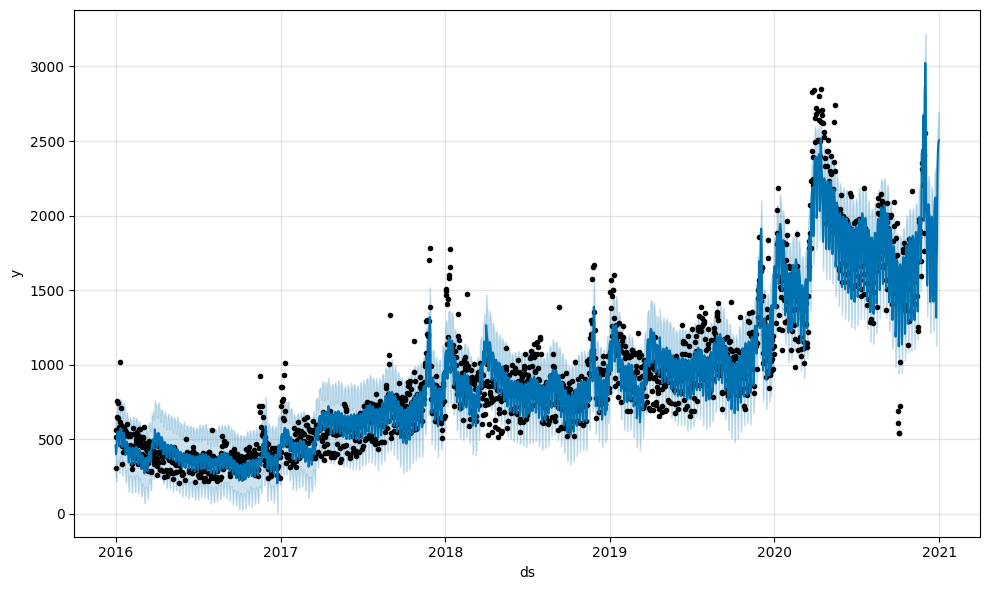

In [126]:
#Forecast
m.plot(forecast);

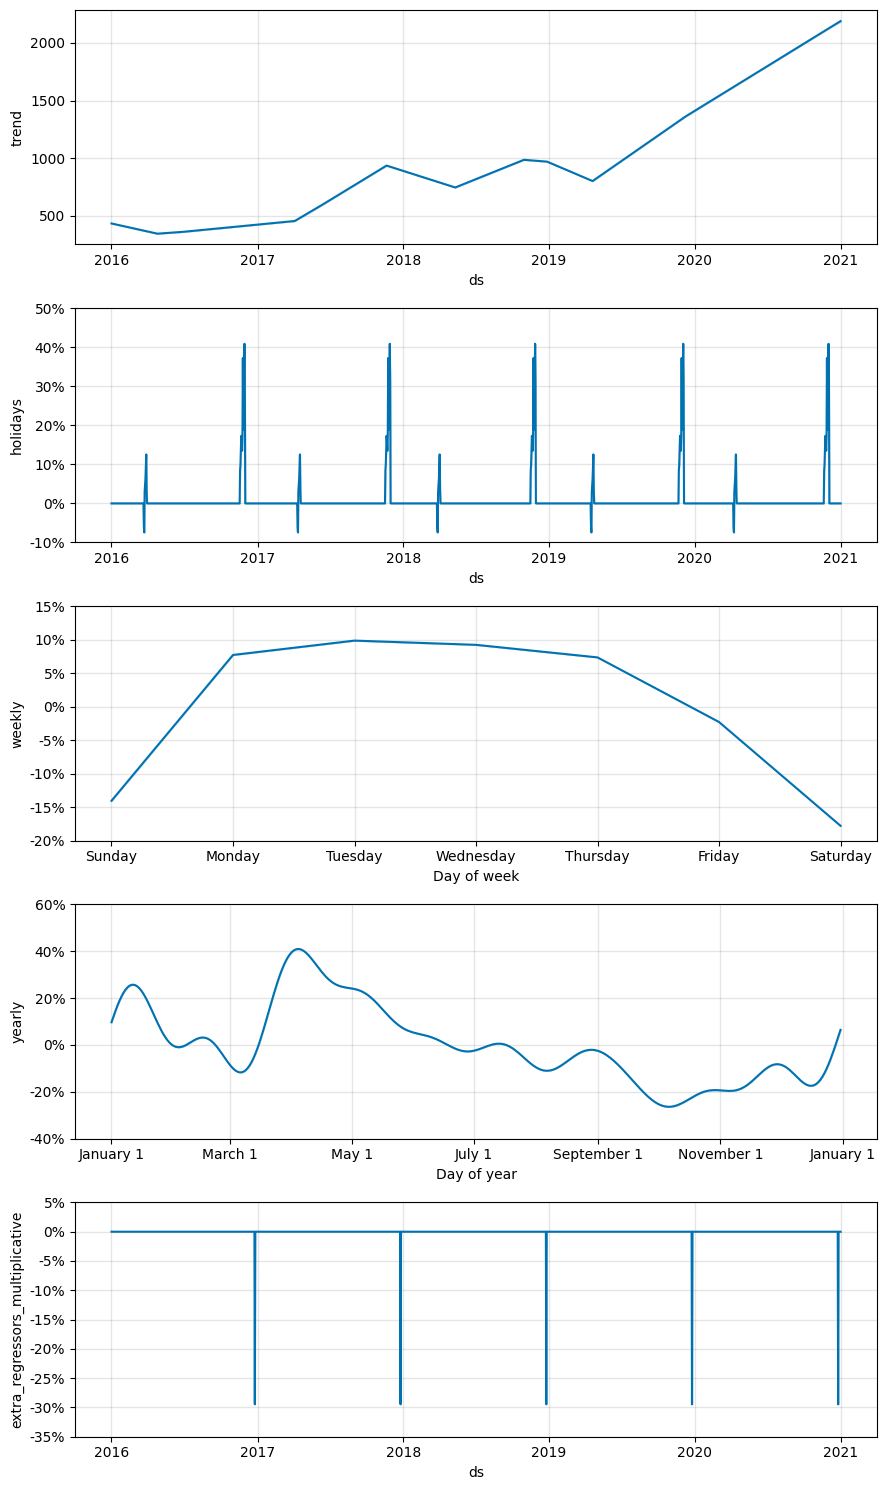

In [127]:
#plot components
m.plot_components(forecast);

#Cross-validation

In [128]:
#CV
from prophet.diagnostics import cross_validation
df_cv=cross_validation(model=m,
                       horizon='31 days',
                       initial='1500 days',
                       parallel= "processes")
df_cv.head()

INFO:prophet:Making 18 forecasts with cutoffs between 2020-02-09 12:00:00 and 2020-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d0b1974e470>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6f3evfo/y2j_n88i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6f3evfo/cvwqvh90.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6f3evfo/cjmswm9k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7900', 'data', 'file=/tmp/tmpe6f3evfo/y2j_n88i.json', 'init=/tmp/tmpe6f3evfo/cjmswm9k.json', 'output', 'file=/tmp/tmpe6f3evfo/prophet_model1g2c7doq/prophet_model-20230825131120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6f3evfo/60g39xpg.json
13:11:20 - cmdstanpy - INFO - Chain [1] start processing
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-02-10,1420.012265,1287.582581,1549.221571,1611,2020-02-09 12:00:00
1,2020-02-11,1468.368418,1335.099163,1597.982246,1528,2020-02-09 12:00:00
2,2020-02-12,1466.785440,1342.864195,1600.998771,1365,2020-02-09 12:00:00
3,2020-02-13,1436.842578,1300.206010,1572.417155,1487,2020-02-09 12:00:00
4,2020-02-14,1301.647958,1172.605086,1438.616240,1265,2020-02-09 12:00:00


In [129]:
#Measure the error
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(df_cv['y'],df_cv['yhat']))
print(np.sqrt(mean_squared_error(df_cv['y'],df_cv['yhat'])))

377.0644273667746
527.1204337664224


#Parameter Tuning

In [134]:
#Grid
from sklearn.model_selection import ParameterGrid
param_grid={'seasonality_prior_scale':[5,10,20],
            'holidays_prior_scale':[5,10,20],
            'changepoint_prior_scale':[0.01,0.05,0.1]}
grid=ParameterGrid(param_grid)
list(grid)[:3]

[{'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 5},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 10},
 {'changepoint_prior_scale': 0.01,
  'holidays_prior_scale': 5,
  'seasonality_prior_scale': 20}]

In [ ]:
#Hyperparameter
rmse=[]
#Parameter tuning loop
for params in grid:
  #model
  m=Prophet(growth='linear',
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            seasonality_mode='multiplicative',
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'],
            changepoint_prior_scale=params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.fit(training_set)
  #Cross-validation
  df_cv=cross_validation(model=m, horizon='31 days',
                         initial='1500 days',
                         parallel="processes")
  #Get the error
  error=np.sqrt(mean_squared_error(df_cv['y'],df_cv['yhat']))
  #Store the results
  rmse.append(error)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6f3evfo/envttjup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6f3evfo/4le3cbni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49956', 'data', 'file=/tmp/tmpe6f3evfo/envttjup.json', 'init=/tmp/tmpe6f3evfo/4le3cbni.json', 'output', 'file=/tmp/tmpe6f3evfo/prophet_modeln1kzmrh7/prophet_model-20230825131911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 18 forecasts with cutoffs between 2020-02-09 12:00:00 and 2020-10-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7d0b11217d90>
DEBUG:cmdstanpy:input tempfile: